# AIB Datahack

So, during my year back in college, studying for an M.Sc in Business Analytics at UCD Smurfit, myself and my good buddy @Pete decided to take on the AIB Datahack which was held in, I think, November 2016. The Datahack was hosted by AIB in their head office in Dublin, and consisted of a full days work (8 hours) tackling a machine learning problem. 

The problem we were presented with that morning was a supervised learning problem. Using what we know, could we find a good algorithm to learn and accurately predict energy ratings for houses in Ireland. We went into the competition confident that we knew what we were doing, but quickly realised we'd a lot to learn. All, in all, it was a worthwhile experience and focused us both on what we needed to learn over the coming months.

Now that I've completed my course and have returned to work, I'm going to try and tackle the problem again, and see if I can do a little better this time around.

First off, using this very useful Kernal I found on Kaggle (https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) I'm going to do a full data exploration of the data we were given for the competition. Once that is complete, I'll dive into some real machine learning.

So without further adieu...lets get stuck in!

## Itinerary 

What I hope to tackle in this notebook is as follows:
1. **Understand the problem.** We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.

2. **Univariable study.** We'll just focus on the dependent variable and try to know a little bit more about it.

3. **Multivariate study.** We'll try to understand how the dependent variable and independent variables relate.

4. **Basic cleaning.** We'll clean the dataset and handle the missing data, outliers and categorical variables.

5. **Test assumptions.** We'll check if our data meets the assumptions required by most multivariate techniques.

In [104]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

So the training data set is pretty big. I'm going to read it all into memory for now but further down the line I plan on looking at better ways of doing this.

In [105]:
# Data Import
df = pd.read_csv("large_data/training.txt", sep='\t', encoding='ISO-8859-1', header=0, low_memory=False, index_col=0)

df.head(3)

,County,Type,Year,RatingType,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,...,EffSecondHeatGenPlant,PercSecondHeat,FuelTypeThirdBoiler,EffThirdHeatGenPlant,PercThirdHeat,HeatingSystemSolarSpace,TotPrimaryEnergyFac,TotCO2Emissions,PrimaryEnergySecondarySpace,EnergyMainWater
BuildingID,,,,,,,,,,,,,,,,,,,,,
190835,Co. Wexford,Mid-terrace house,Y1890.0,Existing,F,418.42,52.04 sq. m,2.10,2.30,0.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,2335.6809
523113,Co. Clare,Detached house,Y1901.0,Existing,G,520.35,147.44 sq. m,2.01,0.75,0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7144.838,4470.0759
271393,Co. Kerry,Detached house,Y1968.0,Existing,D2,281.33,104.84 sq. m,0.38,0.13,0.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2127.347,5837.4729


In [106]:
# Lets check the columns
df.columns

Index(['County', 'Type', 'Year', 'RatingType', 'EnergyRatingCat',
       'EnergyRatingCont', 'GroundFloorArea', 'AvgWallU', 'AvgRoofU',
       'AvgFloorU',
       ...
       'EffSecondHeatGenPlant', 'PercSecondHeat', 'FuelTypeThirdBoiler',
       'EffThirdHeatGenPlant', 'PercThirdHeat', 'HeatingSystemSolarSpace',
       'TotPrimaryEnergyFac', 'TotCO2Emissions', 'PrimaryEnergySecondarySpace',
       'EnergyMainWater'],
      dtype='object', length=140)

141 columns, thats a lot of information to work with. Two of these however are the target variables so I'm going to split these out into their own seperate dataframe.

In [107]:
target_cols = ['EnergyRatingCat', 'EnergyRatingCont']

target = df.loc[:,target_cols]
training = df.copy()
# training = df.drop(target_cols, axis='columns')

## Variable Exploration

In order to have some discipline in our analysis, we can create an Excel spreadsheet with the following columns:

* Variable - Variable name.
* Type - Identification of the variables' type. There are two possible values for this field: 'numerical' or 'categorical'. By 'numerical' we mean variables for which the values are numbers, and by 'categorical' we mean variables for which the values are categories.
* Segment - Identification of the variables' segment. We can define three possible segments: building, space or location. When we say 'building', we mean a variable that relates to the physical characteristics of the building (e.g. 'OverallQual'). When we say 'space', we mean a variable that reports space properties of the house (e.g. 'TotalBsmtSF'). Finally, when we say a 'location', we mean a variable that gives information about the place where the house is located (e.g. 'Neighborhood').
* Expectation - Our expectation about the variable influence in 'SalePrice'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible values.
* Conclusion - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'.
* Comments - Any general comments that occured to us.


This processes ended up being a very useful exercise, and made me properly think about each variable in the dataset. The variables I believe are most important, to begin with are as follows:
* Year
* AvgWallU, AvgRoofU, AvgFloorU, AvgWindowU, AvgDoorU
* ExposedWallArea, ExposedRoofArea
* TotFloorArea, TotWindowArea, TotDoorArea
* MainSHFuel, MainWHFuel, WallStructure

I'll begin with these and explore the other variables later.

## Data Exploration
With the above task complete, lets do the interesting stuff....exploring the data!

We have two columns in our target variable dataframe: EnergyRatingCat and EnergyRatingCont. 

1. **EnergyRatingCat** is the categorical energy rating given to the property (A, B1, C2, etc.)
2. **EnergyRatingCont** on the otherhand is an numerical rating given to the property.

In [108]:
# EnergyRatingCat
target.loc[:, 'EnergyRatingCat'].describe()

count     464502
unique        15
top           D1
freq       61134
Name: EnergyRatingCat, dtype: object

In [109]:
# Is there any null values in this column?
target.loc[:, 'EnergyRatingCat'].isnull().sum()

12

Null values aren't very useful to use, so lets from them.

In [110]:
target = target.drop(target.loc[target['EnergyRatingCat'].isnull()].index)

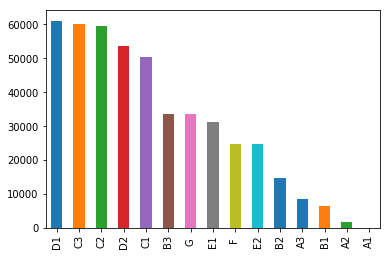

In [111]:
target.loc[:, 'EnergyRatingCat'].value_counts().plot(kind='bar')

Very quickly we see a unbalance in the data towards poorly rated houses, with D1, C2 and C3 appearing most frequently in the data set. Conversely, A1 and A2 are by far the least prevalent.

In [112]:
# EnergyRatingCont
target.loc[:, 'EnergyRatingCont'].describe()

count    464502.000000
mean        260.502160
std         208.511406
min         -63.960000
25%         175.280000
50%         224.290000
75%         299.120000
max       56423.710000
Name: EnergyRatingCont, dtype: float64

In [113]:
# Is there any null values in this column?
target.loc[:, 'EnergyRatingCont'].isnull().sum()

0

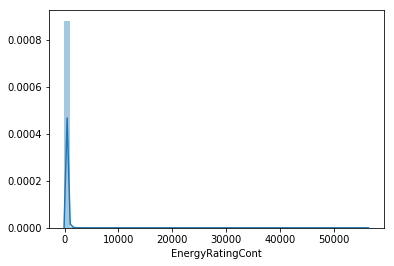

In [114]:
sns.distplot(target['EnergyRatingCont']);

Hmmm...this doesn't look right. Surely there is some sort of outlier skewing this. Lets look at values above 1,000.

In [115]:
outliers = target[target.loc[:, 'EnergyRatingCont']>1000]
outliers.head(10)

,EnergyRatingCat,EnergyRatingCont
BuildingID,,
212192,G,1459.77
644207,G,1284.08
283437,G,1525.85
133323,G,1079.74
513850,G,1200.34
459394,G,1257.39
257884,G,1333.83
92754,G,1273.37
19836,G,2016.71


Ok so we can clearly see that the higher on the scale you go, the worse the energy rating your house will get. Out of curiosity, lets look at the distribution without houses rated above 1000.

In [116]:
target_1000 = target[target.EnergyRatingCont < 1000]
target_1000.head()

,EnergyRatingCat,EnergyRatingCont
BuildingID,,
190835,F,418.42
523113,G,520.35
271393,D2,281.33
585961,C2,188.17
624083,B3,134.95


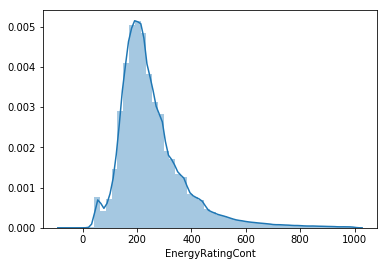

In [117]:
sns.distplot(target_1000['EnergyRatingCont']);

Observations:
1. Deviatea from the normal distribution.
2. Has appreciable positive skewness.
3. Shows peakedness.

In [118]:
#skewness and kurtosis
print("Skewness: %f" % target['EnergyRatingCont'].skew())
print("Kurtosis: %f" % target['EnergyRatingCont'].kurt())

Skewness: 90.929173
Kurtosis: 18601.644571


In [119]:
#skewness and kurtosis
print("Skewness: %f" % target_1000['EnergyRatingCont'].skew())
print("Kurtosis: %f" % target_1000['EnergyRatingCont'].kurt())

Skewness: 1.888031
Kurtosis: 5.466775


### Relationship with numerical variables

In [175]:
important_numerical_cols = ['Year', 'GroundFloorArea', 'AvgWallU', 'AvgRoofU', 'AvgFloorU', 
                  'AvgWindowU', 'AvgDoorU', 'ExposedWallArea', 'ExposedRoofArea', 
                  'TotFloorArea', 'TotWindowArea', 'TotDoorArea', 'EnergyRatingCont']

important_categorical_cols = ['MainSHFuel', 'MainWHFuel', 'WallStructure', 'EnergyRatingCat', 'EnergyRatingCont']

training_num = training.loc[:,important_numerical_cols]
training_cat = training.loc[:,important_categorical_cols]
training_cat.head(3)

,MainSHFuel,MainWHFuel,WallStructure,EnergyRatingCat,EnergyRatingCont
BuildingID,,,,,
190835,Heating Oil,Heating Oil,Masonry,F,418.42
523113,Heating Oil,Heating Oil,Masonry,G,520.35
271393,Heating Oil,Heating Oil,Masonry,D2,281.33


So that all these variables can be properly explored, a little but of processing has to be done to ensure they are all numerical only.

In [121]:
training_num.loc[:, 'Year'].isnull().sum()

0

In [201]:
# First, lets remove the Y from infront of every year
training_num['pYear'] = training_num['Year'].map(lambda x: x[1:])
training_num['pGroundFloorArea'] = training_num['GroundFloorArea'].map(lambda x: float(x[:-5]))

In [202]:
training_num.head(3)

,Year,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,AvgWindowU,AvgDoorU,ExposedWallArea,ExposedRoofArea,TotFloorArea,TotWindowArea,TotDoorArea,EnergyRatingCont,pYear,pGroundFloorArea
BuildingID,,,,,,,,,,,,,,,
190835,Y1890.0,52.04 sq. m,2.10,2.30,0.61,2.71,3.00,32.78,73.08,33.69,7.08,2.05,418.42,1890.0,52.04
523113,Y1901.0,147.44 sq. m,2.01,0.75,0.94,2.63,3.96,211.22,93.40,96.77,37.00,5.95,520.35,1901.0,147.44
271393,Y1968.0,104.84 sq. m,0.38,0.13,0.68,2.81,0.00,94.41,104.84,104.84,17.90,0.00,281.33,1968.0,104.84


In [135]:
training_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464514 entries, 190835 to 429515
Data columns (total 15 columns):
Year                464514 non-null object
GroundFloorArea     464514 non-null object
AvgWallU            418057 non-null float64
AvgRoofU            464502 non-null float64
AvgFloorU           464502 non-null float64
AvgWindowU          464502 non-null float64
AvgDoorU            464502 non-null float64
ExposedWallArea     464502 non-null float64
ExposedRoofArea     464502 non-null float64
TotFloorArea        464502 non-null float64
TotWindowArea       464502 non-null float64
TotDoorArea         464502 non-null float64
EnergyRatingCont    464502 non-null float64
pYear               464514 non-null object
pGroundFloorArea    418342 non-null float64
dtypes: float64(12), object(3)
memory usage: 56.7+ MB


In [141]:
# So that the pYear 
null_pYear = training_num[training_num['pYear']=='nan']
null_
null_pYear.index

Int64Index([ 66956, 413423,  92328,  68216, 415824, 416368,  90347, 417267,
             68842,  67040, 419147, 416075],
           dtype='int64', name='BuildingID')

### Scatter Plots - Numerical Variables

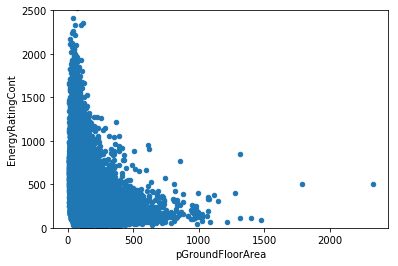

In [162]:
var = 'pGroundFloorArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

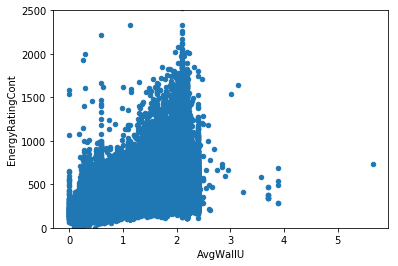

In [163]:
var = 'AvgWallU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

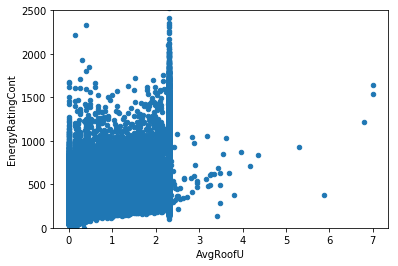

In [164]:
var = 'AvgRoofU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

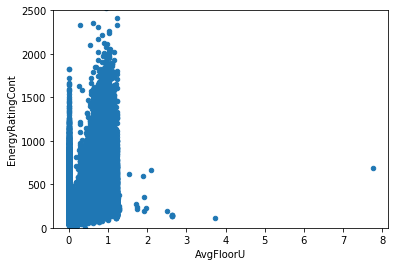

In [165]:
var = 'AvgFloorU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

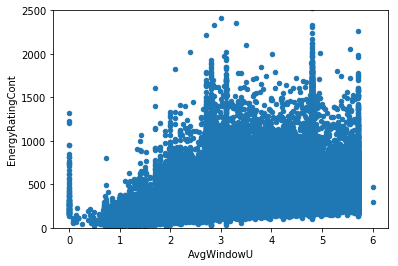

In [166]:
var = 'AvgWindowU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

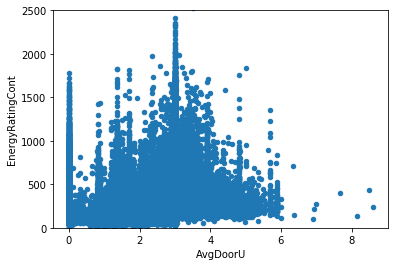

In [167]:
var = 'AvgDoorU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

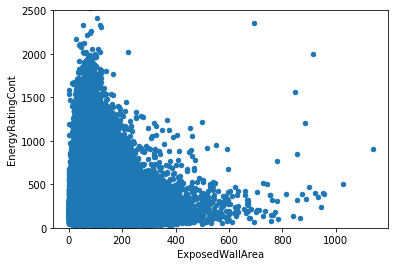

In [168]:
var = 'ExposedWallArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

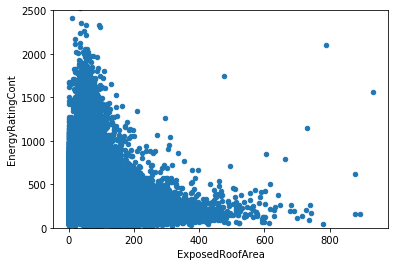

In [169]:
var = 'ExposedRoofArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

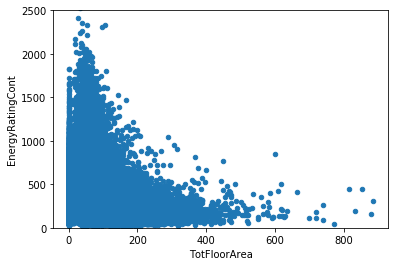

In [170]:
var = 'TotFloorArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

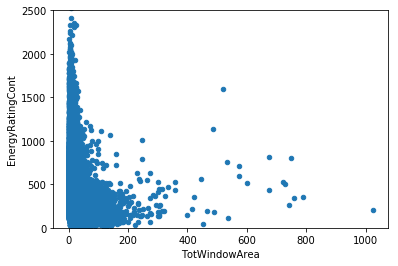

In [171]:
var = 'TotWindowArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

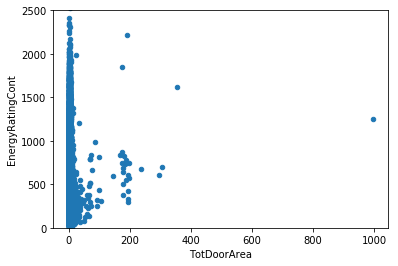

In [172]:
var = 'TotDoorArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

### Scatter Plots - Numerical Variables

In [ ]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

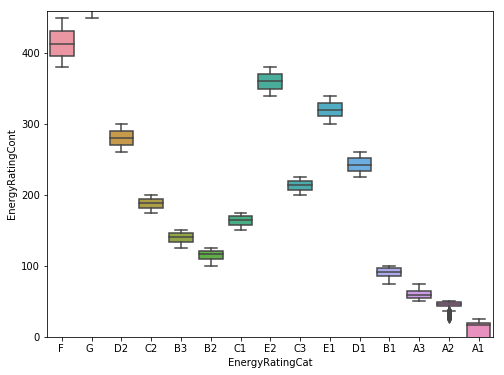

In [184]:
var = 'EnergyRatingCat'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat)
fig.axis(ymin=0, ymax=460);

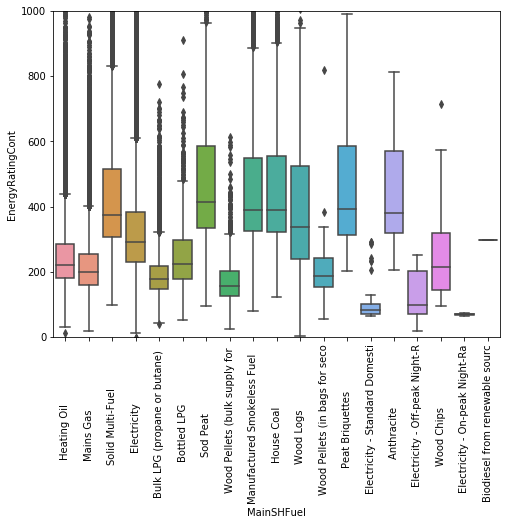

In [196]:
var = 'MainSHFuel'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

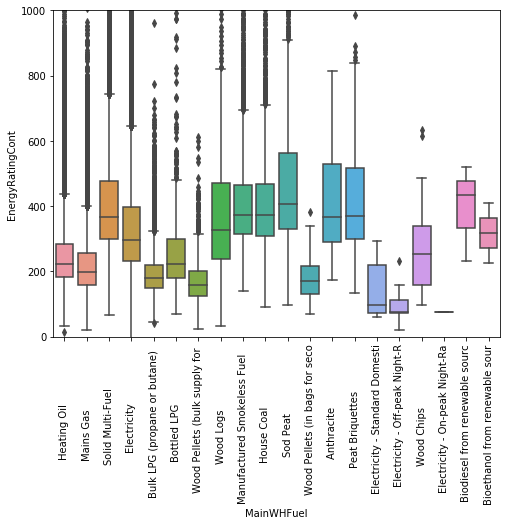

In [195]:
var = 'MainWHFuel'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

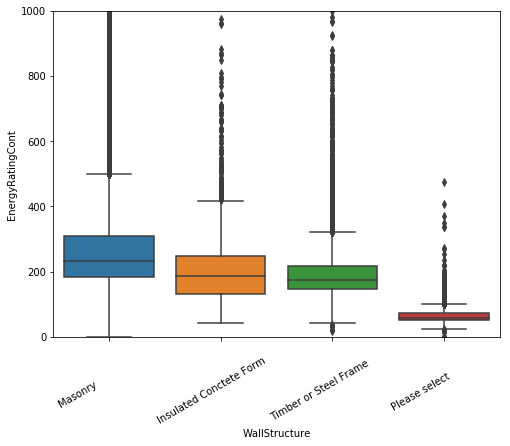

In [194]:
var = 'WallStructure'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat)
fig.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig.axis(ymin=0, ymax=1000);

In [204]:
# Drop nan rows
training_num = training_num[training_num['pYear'] not in null_pYear]
traininf_num.head()

# Only keep rows for houses built this centuary
# training_num_2000plus = training_num[training_num['pYear']>=2000]
# training_num_2000plus.head()

TypeError: 'Series' objects are mutable, thus they cannot be hashed

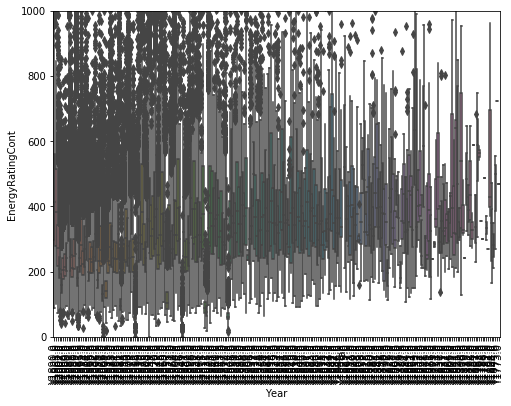

In [199]:
var = 'Year'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_num)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

### Correlation Matrix

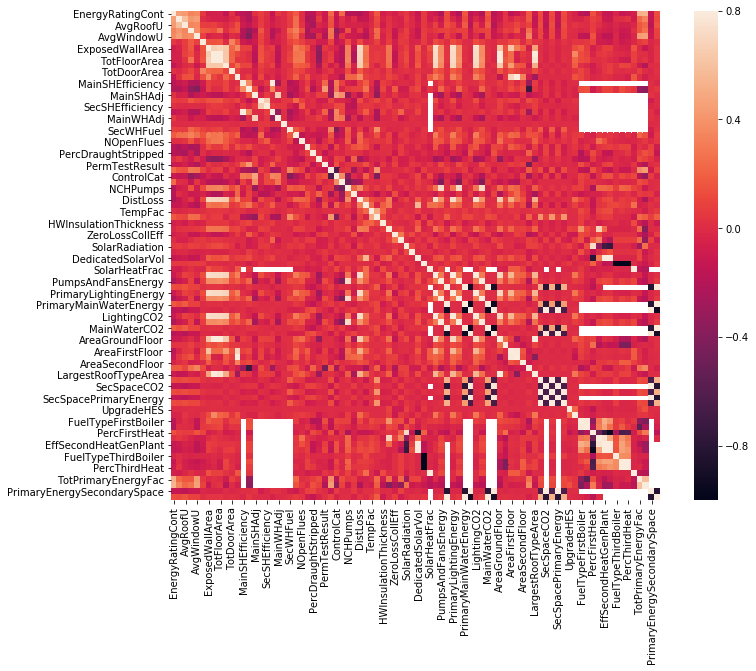

In [205]:
#correlation matrix
corrmat = training.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);